In [0]:
%matplotlib inline

## Install dependencies

**Check for GPU**

First make sure the nvidia-smi command returns information about the available GPU. If it does not, click Runtime > Change runtime type > Hardware accelerator > GPU. Then run the nvidia-smi command again.

In [4]:
!nvidia-smi

Mon Nov 26 08:05:20 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.44                 Driver Version: 396.44                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [5]:
!pip3 install http://download.pytorch.org/whl/cu92/torch-0.4.1-cp36-cp36m-linux_x86_64.whl torchvision

    100% |████████████████████████████████| 512.6MB 47.5MB/s 
tcmalloc: large alloc 1073750016 bytes == 0x57ea2000 @  0x7f1c556b92a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 61kB 2.6MB/s 
    100% |████████████████████████████████| 2.0MB 4.3MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [6]:
!git clone https://github.com/sg2/intro

Cloning into 'intro'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 401 (delta 8), reused 4 (delta 0), pack-reused 379
Receiving objects: 100% (401/401), 17.14 MiB | 36.49 MiB/s, done.
Resolving deltas: 100% (160/160), done.


In [7]:
cd intro/8-EarlyStopping

/content/intro/8-EarlyStopping


Early stopping
=====================
Adapted from https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html

Data should be split into train/dev/test splits.

1. Training set: a set of examples used for learning: to fit the parameters of the classifier.

2. Dev set: a set of examples used to tune the parameters of a classifier. We would use the validation set to find the "optimal" number of hidden units or determine a stopping point for the back-propagation algorithm.

3. Test set: a set of examples used only to assess the performance of a fully-trained classifier. We use this test to estimate the error rate after we have chosen the final model. After assessing the final model on the test set, YOU MUST NOT tune the model any further!

Reference: https://stats.stackexchange.com/questions/19048/what-is-the-difference-between-test-set-and-validation-set

## Early stopping
Early stopping is a technique to prevent over-fitting to the train set.

![](https://github.com/sg2/intro/blob/master/8-EarlyStopping/images/early_stopping.png?raw=1)

## 1. Load and normalizing the CIFAR10 training and test datasets using
Using ``torchvision``, it’s extremely easy to load CIFAR10.

In [0]:
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

Set the device to GPU

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [12]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)

devtestset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Split the devtestset into a dev_set and a test_set

In [0]:
batch_size = 32
test_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
tevtestset_size = len(devtestset)
indices = list(range(tevtestset_size))
split = int(np.floor(test_split * tevtestset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
dev_indices, test_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
dev_sampler = SubsetRandomSampler(dev_indices)
test_sampler = SubsetRandomSampler(test_indices)

devloader = torch.utils.data.DataLoader(devtestset, batch_size=batch_size, 
                                           sampler=dev_sampler)
testloader = torch.utils.data.DataLoader(devtestset, batch_size=batch_size,
                                                sampler=test_sampler)

Let us show some of the training images, for fun.



horse  bird  ship   dog horse truck plane plane  frog horse  bird  deer   car  bird   dog plane truck truck  deer truck plane   dog   cat plane   dog  frog   dog   car plane  ship horse truck


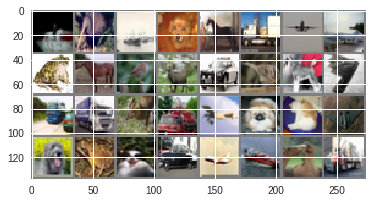

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(32)))

## 2. Define a Convolution Neural Network

Needs 3 channels for first layer.



In [48]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

## 3. Define a Loss function and optimizer

Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 4. Train the network


This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [50]:
# Overfit the data
num_epochs = 50

# Used for tracking loss and plotting later
train_losses = []
dev_losses = []

print('Training...')
for epoch in range(num_epochs):  # loop over the dataset multiple times
    print('Epoch', epoch)
    train_loss = 0.0   
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
      
        # Send the inputs to GPU if available
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # track loss for printing
        train_loss += loss.item()
       
    # print average dev loss
    avg_train_loss = train_loss/len(trainloader)
    print('  average train mini-batch loss: {:.6f}'.format(avg_train_loss))
    train_losses.append(avg_train_loss)

    # Calculate dev loss after every epoch
    with torch.no_grad():
        dev_loss = 0.0
        for data in devloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            dev_loss += loss.item()
        avg_dev_loss = dev_loss/len(devloader)
        print('  average dev mini-batch loss: {:.6f}'.format(avg_dev_loss))
        dev_losses.append(avg_dev_loss)
            
    # Save the model so we can restore later
    print('  saving model checkpoint')
    # See https://pytorch.org/tutorials/beginner/saving_loading_models.html
    torch.save(net.state_dict(), 'net_checkpoint_{}.pth'.format(epoch))

print('Finished Training')

Training...
Epoch 0
  average train mini-batch loss: 2.196991
  average dev mini-batch loss: 2.029254
  saving model checkpoint
Epoch 1
  average train mini-batch loss: 1.830112
  average dev mini-batch loss: 1.629191
  saving model checkpoint
Epoch 2
  average train mini-batch loss: 1.562340
  average dev mini-batch loss: 1.488396
  saving model checkpoint
Epoch 3
  average train mini-batch loss: 1.448092
  average dev mini-batch loss: 1.402031
  saving model checkpoint
Epoch 4
  average train mini-batch loss: 1.365379
  average dev mini-batch loss: 1.335902
  saving model checkpoint
Epoch 5
  average train mini-batch loss: 1.290754
  average dev mini-batch loss: 1.301041
  saving model checkpoint
Epoch 6
  average train mini-batch loss: 1.227836
  average dev mini-batch loss: 1.197109
  saving model checkpoint
Epoch 7
  average train mini-batch loss: 1.167845
  average dev mini-batch loss: 1.219783
  saving model checkpoint
Epoch 8
  average train mini-batch loss: 1.114517
  average 

Process Process-245:
Process Process-246:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 104, in get
    if not self._poll(timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 414, in _poll
    r = wait([self], timeout)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 257, in poll
    r

KeyboardInterrupt: ignored

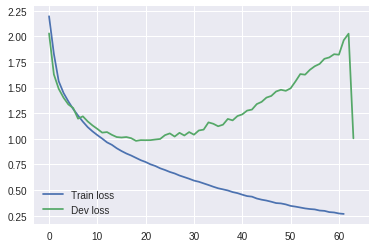

In [69]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(train_losses, label='Train loss')
plt.plot(dev_losses, label='Dev loss')
plt.legend()
plt.show()

Find epoch with minimum dev loss

In [0]:
best_epoch = np.argmin(dev_losses)

Load model which resulted in minimum loss

In [59]:
best_net = Net()
best_net.load_state_dict(torch.load('net_checkpoint_{}.pth'.format(best_epoch)))
best_net.eval()
best_net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

## 5. Test the network on the test data


In [60]:
# Calculate dev loss after every epoch
with torch.no_grad():
    test_loss = 0.0
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = best_net(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
    avg_test_loss = test_loss/len(testloader)
    print('  average test mini-batch loss: {:.6f}'.format(avg_test_loss))

  average test mini-batch loss: 1.005007


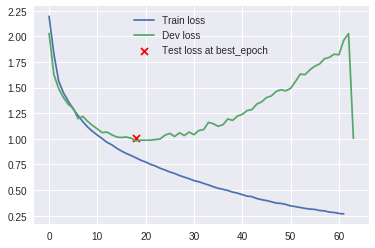

In [70]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(train_losses, label='Train loss')
plt.plot(dev_losses, label='Dev loss')
plt.scatter(best_epoch, avg_test_loss, marker='x', color='r', label='Test loss at best_epoch')
plt.legend()
plt.show()
